In [1]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from quantstats.stats import sharpe
from utils.func import center
import matplotlib.pyplot as plt

In [7]:
market_data = pd.read_parquet('data/US/mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['close'].unstack().reindex_like(P).pct_change()

In [24]:
DATA = pd.read_parquet('data/US/STRAT_EARNINGS/')
DATA.drop('SnpDate',axis=1,inplace=True)
DATA = DATA.set_index(['Date','Ticker'])
DATA = DATA['SIGNAL'].unstack()
DATA

Ticker,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACGL,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-21,-1.963066,NaN,-1.281828,-1.441526,1.301728,-0.798448,2.681333,NaN,-1.296180,0.000000,...,0.0,0.703148,-0.219746,NaN,-0.673696,-0.997610,0.000000,NaN,NaN,-0.489771
2016-01-22,-1.962663,NaN,-1.319762,-1.571525,1.572226,-0.894630,3.964070,NaN,-1.221461,0.000000,...,0.0,0.725184,-0.136460,NaN,-0.716575,-1.087035,0.000000,NaN,NaN,-0.579114
2016-01-25,-1.954133,NaN,-1.304130,-1.680574,1.766860,-0.953753,5.775360,NaN,-1.133157,0.000000,...,0.0,0.744133,-0.143848,NaN,-0.721115,-0.957532,0.000000,NaN,NaN,-0.613935
2016-01-26,-1.937440,NaN,-1.252705,-1.771369,2.082025,-1.008480,8.502602,NaN,-0.978475,0.000000,...,0.0,0.815921,-0.100251,NaN,-0.722901,-0.625946,0.000000,NaN,NaN,-0.628704
2016-01-27,-1.904878,NaN,-1.206682,-1.847082,11.252327,-1.016412,13.056545,NaN,-0.842055,0.000000,...,0.0,0.459058,-0.113586,NaN,-0.658443,-0.678002,0.000000,NaN,NaN,-0.598857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-22,-0.929633,0.0,0.000000,3.904866,-1.204575,-0.922671,-0.650039,-0.478438,-0.833549,-1.243298,...,NaN,1.933923,NaN,NaN,-0.806520,-0.640729,4.218219,-0.989762,NaN,-1.316609
2022-07-25,-0.861960,0.0,0.000000,5.675591,-0.955794,-0.902191,-0.672312,-0.444853,-0.903289,-1.181174,...,NaN,2.262202,NaN,NaN,-0.749229,-0.546352,3.165404,-0.747615,NaN,-1.363219
2022-07-26,-0.871473,0.0,0.000000,8.340568,-1.001652,-1.021410,-0.670303,-0.480214,-0.890146,-1.101403,...,NaN,2.209032,NaN,NaN,-0.709718,-0.545662,2.332653,0.554698,NaN,-1.384130


C:\Users\marti\AppData\Local\Temp\ipykernel_15608\1588128175.py:3: FutureWarning: Passing additional kwargs to Rolling.rank has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  signal = signal[P].rolling(20,min_periods=5).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
C:\Users\marti\AppData\Local\Temp\ipykernel_15608\1588128175.py:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicind'],axis=1).apply(center)


Sharpe      0.0
Turnover    0.1
biais       0.0
dtype: float64

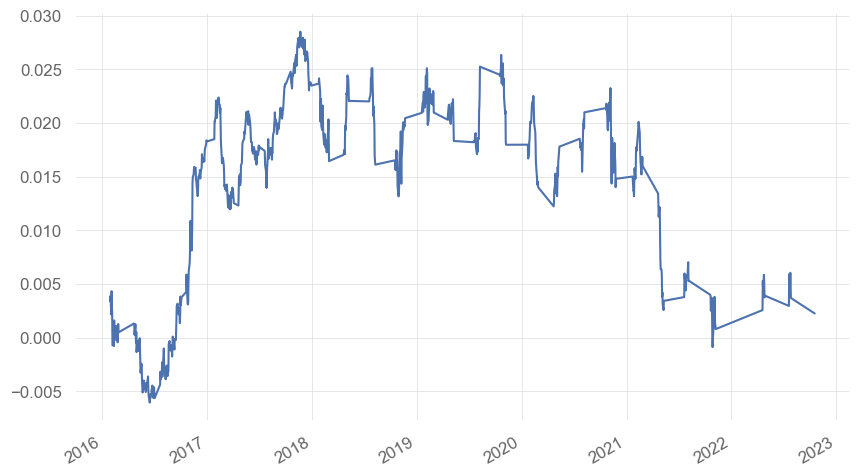

In [26]:
signal =DATA.copy()
signal = signal[P].rank(axis=1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
signal = signal[P].rolling(20,min_periods=5).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
signal = signal.reindex_like(P)
signal = signal[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)

signal[signal.abs()<0.3] = None

signal = signal[P].groupby(GICS['gicind'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)

PNL = (signal[P].shift()*R).sum(1).replace({0:np.nan}).dropna()
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':PNL.mean()*1e4}).round(1)